In [4]:
from utils import find_REM, load_data

import re

import emd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series

from bycycle.features import compute_features
from bycycle.plts import plot_burst_detect_param

In [24]:
# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

threshold_kwargs = {'amp_fraction_threshold': 0.8,
                        'amp_consistency_threshold': 0,
                        'period_consistency_threshold': 0,
                        'monotonicity_threshold': 0,
                        'min_n_cycles': 8}

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

def extract_title(fname):
   # Define a single regex pattern to capture both rat number and "SD" part
   pattern = r'Rat(\d+).*?SD(\d+)'
   
   # Use re.search to find matches in the filename
   match = re.search(pattern, fname)
   
   # Check if a match is found
   if match:
       rat_number = match.group(1)  # Extract the rat number from the first captured group
       sd_number = match.group(2)   # Extract the "SD" number from the second captured group
   else:
       return 'none'
   
   return 'Rat_' + rat_number + ' SD_' + sd_number


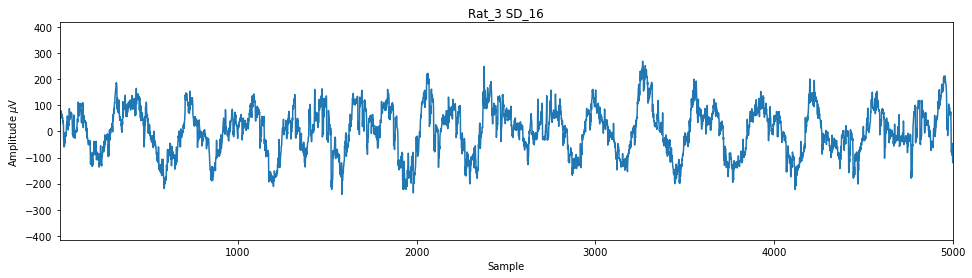

In [16]:
REM_files = find_REM()

rem = REM_files[0]
dataREM = load_data(rem)
lfpREM = dataREM[0]

title = extract_title(str(rem))

# Now plotting the data to inspect them
plt.figure(figsize=(16,4))
plt.plot(lfpREM)
plt.xlim((1,5000))
plt.xlabel('Sample')
plt.ylabel('Amplitude $\mu$V');
plt.title(title);

(5.0, 10.0)

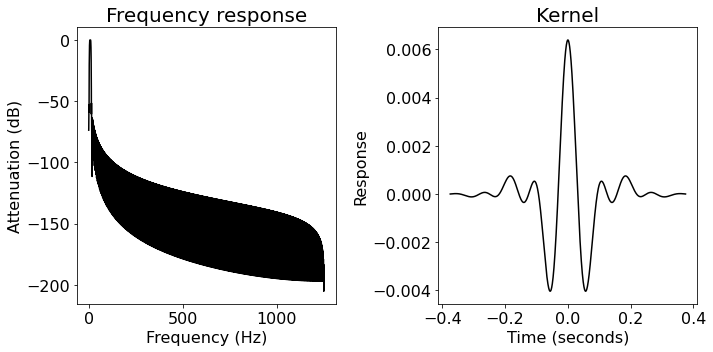

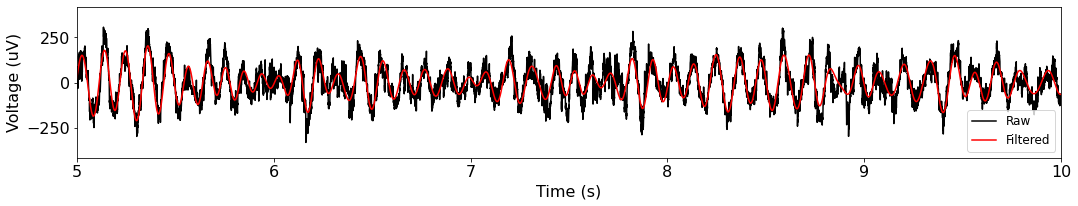

In [17]:
#Filtering the signal
sig_low = filter_signal(lfpREM, 1000, 'lowpass', f_lowpass, n_seconds=n_seconds_filter, remove_edges=False)
sig_filt = filter_signal(lfpREM, fs, 'bandpass', f_theta, n_seconds=.75, plot_properties=True, remove_edges=False)

times = np.arange(0, len(lfpREM)/fs, 1/fs)

theta = sig_filt

plot_time_series(times, [lfpREM, theta], ['Raw', 'Filtered'])
plt.xlim(5, 10)

## EMD analysis

In [22]:
IP, IF, IA = emd.spectra.frequency_transform(theta, fs, 'hilbert', smooth_phase=3)

C = emd.cycles.Cycles(IP.flatten())
print("Detected cycles before extraction:")
print(C)

# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', theta, emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', theta, emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', theta, emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', theta, emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', theta, len)

C.compute_cycle_metric('max_amp', IA, np.max)
C.compute_cycle_metric('mean_if', IF, np.mean)
C.compute_cycle_metric('max_if', IF, np.max)
C.compute_cycle_metric('range_if', IF, compute_range)

C.compute_cycle_metric('asc2desc', theta, asc2desc)
C.compute_cycle_metric('peak2trough', theta, peak2trough)

print('\nFinished computing the cycles metrics\n')

# Extract subset of the cycles 
amp_thresh = np.percentile(IA, 25)
lo_freq_duration = fs/5
hi_freq_duration = fs/12
conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

C.pick_cycle_subset(conditions)
print("Cycles after extraction:")
print(C)

Detected cycles before metrics:
<class 'emd.cycles.Cycles'> (708 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
<class 'emd.cycles.Cycles'> (708 cycles 612 subset 69 chains - 14 metrics) 


In [26]:
df_emd = C.get_metric_dataframe()
df_emd

,is_good,start_sample,stop_sample,peak_sample,desc_sample,trough_sample,duration_samples,max_amp,mean_if,max_if,range_if,asc2desc,peak2trough,chain_ind
0,0,0,-0.003923,68.530849,131.119119,218.167655,303,97.149106,6.979482,8.130861,65.752555,0.506149,0.432736,-1
1,1,303,-1.131967,101.82148,196.093093,282.142839,361,119.795496,6.916477,8.302221,2.191362,0.500495,0.543194,0
2,1,664,-0.377009,67.503182,141.424424,211.766484,289,112.072061,8.657272,9.090717,1.249985,0.500819,0.489358,0
3,1,953,-0.004368,82.214876,163.921922,240.016236,342,87.832449,7.312627,7.834274,1.739488,0.538593,0.479304,0
4,1,1295,-0.172139,111.940302,190.408408,271.0436,355,67.919135,7.040358,7.941801,2.218722,0.551822,0.536362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,1,239474,-0.917695,89.820475,162.039039,242.510049,332,67.269966,7.532800,7.921938,1.224454,0.540092,0.488069,69
704,1,239806,-1.742032,105.241566,193.082082,287.993531,377,110.392154,6.628745,6.898502,0.530937,0.515247,0.512154,69
705,0,240183,-0.091237,78.568204,188.503504,244.523502,605,105.842325,4.136223,6.898242,9.014096,0.725694,0.311576,-1
706,0,240788,-0.048807,91.995526,183.163163,411.301559,482,33.151303,5.195476,8.287089,42.403852,0.337539,0.380007,-1


## Bycycle analysis

In [45]:
df_byc = compute_features(theta, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

len(df_theta_phasic)


def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

df_byc

,amp_fraction,amp_consistency,period_consistency,monotonicity,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,...,time_rdsym,time_ptsym,band_amp,sample_peak,sample_last_zerox_decay,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,is_burst
0,0.603399,NaN,NaN,1.000000,367,199,160,99.992136,-89.518250,180,...,0.509537,0.554318,99.543321,405,145,504,305,218,585,False
1,0.552408,0.813508,0.792916,1.000000,291,142,154,96.949266,-119.792761,144,...,0.505155,0.479730,99.624735,732,504,800,658,585,876,False
2,0.344193,0.764196,0.849866,1.000000,317,158,154,87.092130,-79.372202,158,...,0.501577,0.506410,80.004001,1035,800,1112,954,876,1193,False
3,0.138810,0.764196,0.849866,1.000000,373,214,167,49.105774,-74.000992,159,...,0.573727,0.561680,59.455983,1407,1112,1493,1279,1193,1566,False
4,0.307365,0.753708,0.918848,1.000000,382,224,155,65.318428,-67.420389,177,...,0.536649,0.591029,75.477959,1771,1493,1872,1648,1566,1948,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,0.155807,0.829213,0.828571,0.897351,455,228,217,59.656536,-68.223003,153,...,0.663736,0.512360,45.683112,239564,239193,239638,239410,239262,239717,False
702,0.351275,0.771066,0.828571,1.000000,377,198,172,77.683542,-66.582261,183,...,0.514589,0.535135,84.087555,239911,239638,240008,239810,239717,240094,False
703,0.259207,0.316625,0.594306,1.000000,334,156,168,84.858960,-109.415547,166,...,0.502994,0.481481,74.060932,240262,240008,240332,240176,240094,240428,False
704,0.004249,0.316625,0.371886,0.865044,562,151,452,15.555402,-16.554647,110,...,0.804270,0.250415,9.283722,240880,240332,240935,240784,240428,240990,False


In [62]:
# Peak to Trough ratio for Bycyle Cycle
p = df_byc.time_peak
t = df_byc.time_trough
p2t = p/(p+t)
p2t

0      0.554318
1      0.479730
2      0.506410
3      0.561680
4      0.591029
         ...   
701    0.512360
702    0.535135
703    0.481481
704    0.250415
705    0.519608
Length: 706, dtype: float64

In [64]:
# Ascending to Descending ratio for Bycyle Cycle
A = df_byc.time_rise
D = df_byc.time_decay
asc2desc = A/(A+D)

## Comparison between the two

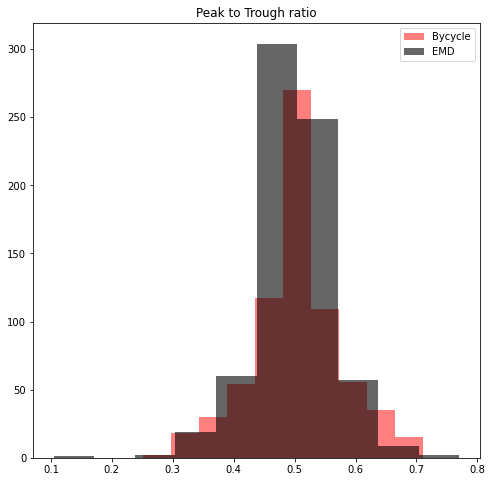

In [66]:
n_bins = 10

dist1 = p2t
dist2 = df_emd['peak2trough']
# Plot the histograms with titles
plt.figure(figsize=(8,8))
plt.hist(dist1, bins=n_bins, alpha=0.5, label='Bycycle', color='r')
plt.hist(dist2, bins=n_bins, alpha=0.6, label='EMD', color='k')
plt.title('Peak to Trough ratio')
plt.legend()

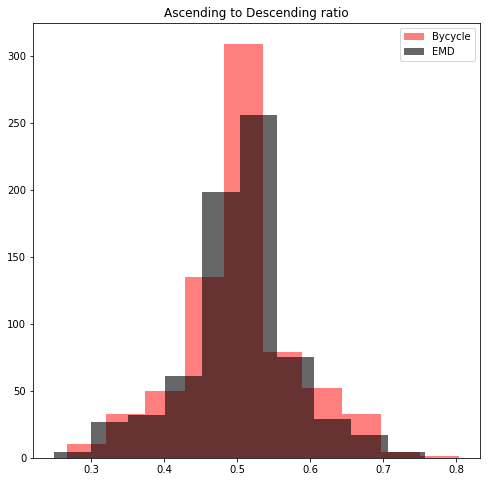

In [67]:
n_bins = 10

dist1 = asc2desc
dist2 = df_emd['asc2desc']

# Plot the histograms with titles
plt.figure(figsize=(8,8))
plt.hist(dist1, bins=n_bins, alpha=0.5, label='Bycycle', color='r')
plt.hist(dist2, bins=n_bins, alpha=0.6, label='EMD', color='k')
plt.title('Ascending to Descending ratio')
plt.legend()